In [1]:
import torch
import matplotlib.pyplot as plt
from AutoEncoder import AutoEncoder
from stochman import nnj

#f_mnist = torch.load("picked_F_MNIST.t")
mnist = torch.load("picked_MNIST.t")[:5000]

def encoder(data_dim, latent_dim):
	encoder = nnj.Sequential(
		nnj.Linear(data_dim, 500), nnj.ELU(),
		nnj.Linear(500,250), nnj.ELU(),
		nnj.Linear(250,150), nnj.ELU(),
		nnj.Linear(150,100), nnj.ELU(),
		nnj.Linear(100,50), nnj.ELU(),
		nnj.Linear(50,2)
		)
	return encoder

def decoder(data_dim, latent_dim):
	decoder = nnj.Sequential(
		nnj.Linear(2,50), nnj.ELU(),
		nnj.Linear(50,100), nnj.ELU(),
		nnj.Linear(100,150), nnj.ELU(),
		nnj.Linear(150,250), nnj.ELU(),
		nnj.Linear(250,500), nnj.ELU(),
		nnj.Linear(500,data_dim)
		)
	return decoder

experiment_name = 'reach_reg_split_training_constant_2'
it_no = '190'
no_it = 191


mnist_ae = AutoEncoder(encoder(784,2), decoder(784,2))
mnist_ae.load(f"out/{experiment_name}/{experiment_name}_reach_trained.pt")

In [2]:
or_ae = AutoEncoder(encoder(784,2), decoder(784,2))
or_ae.load(f"out/{experiment_name}/{experiment_name}_ae_trained.pt")

In [3]:
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
pretrain_loss = torch.load(f"out/{experiment_name}/loss_curve.t")

In [5]:
l2_losses = torch.load(f"out/{experiment_name}/l2_losses_iter_{it_no}.pt")
reach_losses = torch.load(f"out/{experiment_name}/reach_losses_{it_no}.pt")
reach_points = torch.load(f"out/{experiment_name}/reach_points_{it_no}.pt")

In [6]:
ar_2 = torch.arange(190)

In [7]:
in_reach_per = torch.tensor(reach_points)/5000

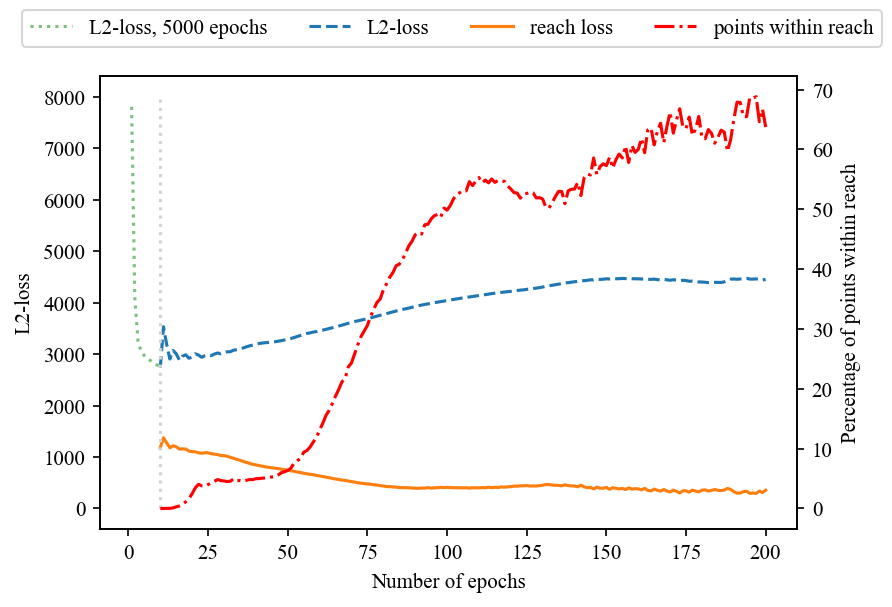

In [10]:
ar = torch.arange(no_it)
fig, ax = plt.subplots(dpi = 150)
ax2 = ax.twinx()
ax.plot(torch.arange(10)+1, pretrain_loss[::500], color = 'green', linestyle = 'dotted', alpha = 0.5, label = 'L2-loss, 5000 epochs')
ax.plot(ar+10, l2_losses, label = 'L2-loss', linestyle = 'dashed')

ax.plot(ar+10, reach_losses, label = 'reach loss')
ax2.plot(ar+10, (1-in_reach_per)*100, color = 'red', label = 'points within reach', linestyle = 'dashdot')
#ax2.plot(ar_2 + no_it + 10,in_reach_per_2)
ax.vlines(10, 0 , 8000, linestyle = 'dotted', color = 'lightgrey')


ax.set_xlabel('Number of epochs')
ax.set_ylabel('L2-loss')
ax2.set_ylabel('Percentage of points within reach')
fig.legend(ncol = 4)
fig.savefig("initial_reach_regularisation.jpeg")


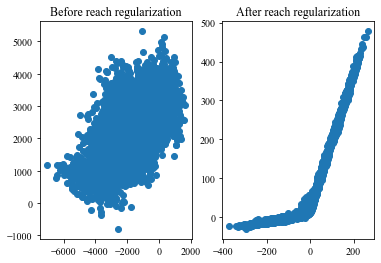

In [42]:
fig , axis = plt.subplots(1,2)
axis[0].scatter(*or_ae.encoder(mnist).detach().T)
axis[0].set_title('Before reach regularization')
axis[1].scatter(*mnist_ae.encoder(mnist).detach().T)
axis[1].set_title('After reach regularization')
fig.savefig('latentspace.jpeg')

In [39]:
axis

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [12]:
mnist_target = torch.load("picked_MNIST_targest.t")

In [13]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [14]:
from reach import reach_est

ImportError: cannot import name 'reach_est' from 'reach' (C:\Users\au481503\DTU_project\rebutal_reach_reg\reach.py)

In [15]:
# MNIST_AE
rr_x, rr_D = mnist_ae.decoder(or_ae.encoder(mnist),jacobian = True)
rr_pjac = torch.permute(rr_D, (0,2,1))
rr_proj_mat = torch.eye(784) -  rr_D@torch.linalg.solve(rr_pjac@rr_D, rr_pjac)

In [16]:
from tqdm import tqdm

In [17]:
def batch_cloud_reach_est(z_space,r,n_samples,batch_size, model):
    r_new = torch.zeros(len(z_space))
    enum_z_space = torch.cat((torch.arange(len(z_space)).unsqueeze(1), z_space),dim =1)
    loader = torch.utils.data.DataLoader(enum_z_space, batch_size = batch_size, shuffle = True)
    for batch in tqdm(loader):
        batch_x, batch_jacs = model.decoder(batch[:,1:],jacobian = True)
        batch_r = r[batch[:,0].long()]
        n,d = batch_x.shape
        #cloud = 4*batch_r.reshape(n,1,1)*(2*torch.rand(n,n_samples,d)-1)+batch_x.unsqueeze(1)
        u = torch.randn(n,n_samples,d)
        u = u/torch.norm(u, dim = 2).unsqueeze(2)*((torch.rand(n,n_samples,1))**(1.0/d))*2*batch_r.unsqueeze(1).unsqueeze(1)
        cloud = u + batch_x.unsqueeze(1)

        proj_cloud = model.decoder(model.encoder(cloud))-batch_x.unsqueeze(1)
        proj_mat = torch.eye(d)-torch.linalg.lstsq(torch.transpose(batch_jacs,1,2),torch.transpose(batch_jacs,1,2)).solution
        val = torch.min(torch.linalg.norm(proj_cloud,dim=2)**2/(2*torch.linalg.norm(torch.bmm(proj_mat, proj_cloud.movedim(1,2)),dim=1)),dim = 1).values
        r_new[batch[:,0].long()] = val.detach()
    
    return r_new
    

In [18]:
mnist_error = torch.linalg.norm(mnist-mnist_ae(mnist),dim = 1)

In [19]:
mnist_r_2 = batch_cloud_reach_est(mnist_ae.encoder(mnist),mnist_error, 1000, 10,mnist_ae )

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [07:41<00:00,  1.08it/s]


In [20]:
mnist_in = mnist_error < mnist_r_2

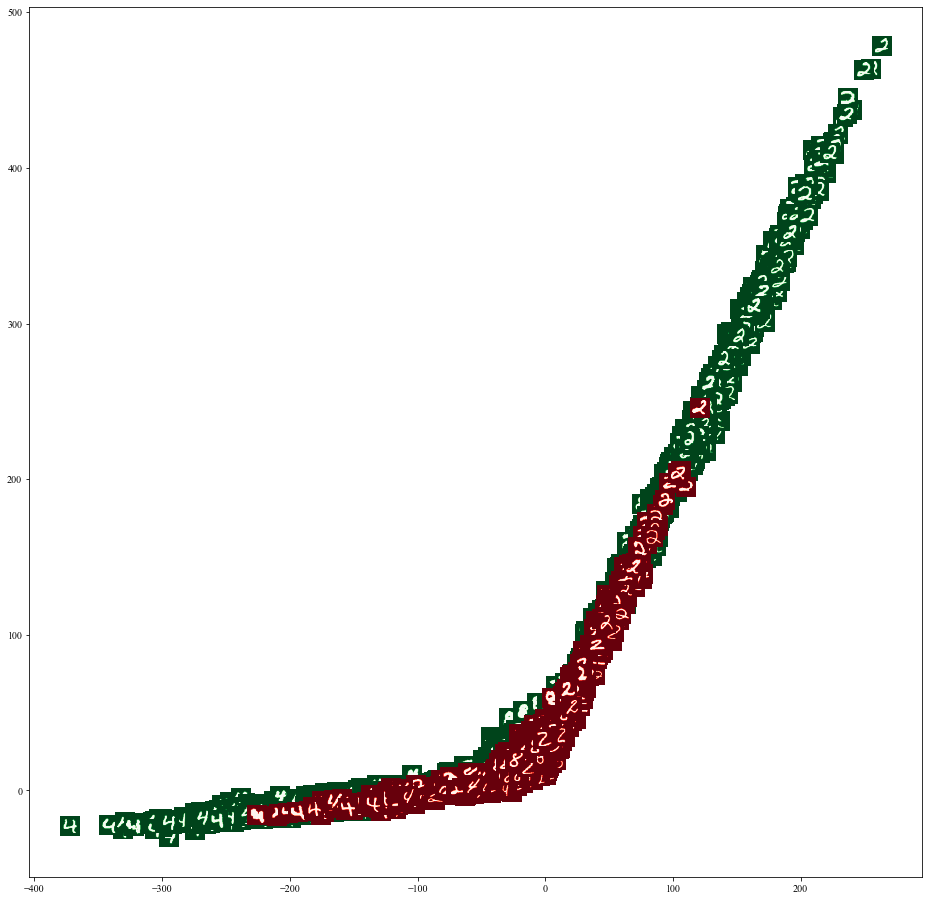

In [21]:
zoom = 0.7
fig,ax = plt.subplots(figsize = (16,16))
mnist_z = mnist_ae.encoder(mnist)
in_z = mnist_z[mnist_in]
mnist_im_in = mnist[mnist_in]
for n in range(len(in_z)):
    image = mnist_im_in[n,:].detach().numpy().reshape((28,28))
    im = OffsetImage(image, zoom = zoom, cmap=plt.cm.Greens_r)
    ab = AnnotationBbox(im,(in_z[n,0].detach().numpy().flatten(), in_z[n,1].detach().numpy().flatten()), xycoords = 'data', frameon = False, alpha = 0.5)
    ax.add_artist(ab)
    ax.autoscale()
    ax.update_datalim([[in_z[:,0].detach().numpy().min(), in_z[:,1].detach().numpy().min()],
                   [in_z[:,0].detach().numpy().max(), in_z[:,1].detach().numpy().max()]])
    
out_z = mnist_z[~mnist_in]
mnist_im_out = mnist[~mnist_in]
for n in range(len(out_z)):
    image = mnist_im_out[n,:].detach().numpy().reshape((28,28))
    im = OffsetImage(image, zoom = zoom, cmap=plt.cm.Reds_r)
    ab = AnnotationBbox(im,(out_z[n,0].detach().numpy().flatten(), out_z[n,1].detach().numpy().flatten()), xycoords = 'data', frameon = False, alpha = 0.5)
    ax.add_artist(ab)
    ax.autoscale()
    ax.update_datalim([[out_z[:,0].detach().numpy().min(), out_z[:,1].detach().numpy().min()],
                   [out_z[:,0].detach().numpy().max(), out_z[:,1].detach().numpy().max()]])
fig.savefig("regularized_latent.pdf", format = 'pdf')

In [38]:
reach_est_r = reach_est(mnist_ae(mnist),rr_proj_mat, mnist_error, mnist_ae.encoder, mnist_ae.decoder, 1000)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 15680000000 bytes.

In [43]:
reach_est_test = reach_est(mnist_ae(mnist)[:10],rr_proj_mat[:10], mnist_error[:10], mnist_ae.encoder, mnist_ae.decoder, 1000)

batch_est_test = batch_cloud_reach_est(mnist_ae.encoder(mnist)[:10],mnist_error[:10], 1000, 10,mnist_ae )

In [41]:
reach_est_r

tensor([2493.9897, 2114.0400, 2316.1355, 5048.4946, 3881.6270, 2881.1304,
        2202.4683, 2827.4521, 3352.0698, 2927.1104], grad_fn=<MinBackward0>)

In [42]:
mnist_r_2

tensor([2488.6809, 1995.3865, 2376.5918, 5306.2744, 3983.0540, 2921.3745,
         360.5384, 3140.3396, 3835.5630, 2865.0767])

In [60]:
reach_est_test = torch.zeros(1000,10)
batch_est_test = torch.zeros(1000,10)
for i in tqdm(range(1000)):
    reach_est_test[i] = reach_est(mnist_ae(mnist)[:10],rr_proj_mat[:10], mnist_error[:10], mnist_ae.encoder, mnist_ae.decoder, 1000).detach()
    batch_est_test[i] = batch_cloud_reach_est(mnist_ae.encoder(mnist)[:10],mnist_error[:10], 1000, 10,mnist_ae )

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


  9%|███████                                                                         | 89/1000 [04:02<41:01,  2.70s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 22%|█████████████████▌                                                             | 223/1000 [10:13<35:04,  2.71s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 36%|████████████████████████████▏                                                  | 357/1000 [16:22<28:06,  2.62s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 49%|██████████████████████████████████████▊                                        | 491/1000 [22:45<25:11,  2.97s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [28:51<17:27,  2.79s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [34:52<11:25,  2.84s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [42:14<05:37,  3.15s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [47:19<00:00,  2.84s/it]


In [55]:
reach_est_test

tensor([ 742.2049, 1834.5509,  669.9726,  753.3884,  747.1405, 1368.6685,
        1071.7799, 1391.9590,  737.2004,  992.5504], grad_fn=<MinBackward0>)

In [56]:
batch_est_test

tensor([ 386.1755, 1654.8853, 1735.1891,  982.1318,  942.7965,  713.6770,
         419.9464,  955.9700,  825.0309,  714.7159])

In [76]:
reach_est_test-reach_est_test.min(dim = 0).values

tensor([[ 176.9404, 1979.4999, 1817.4175,  ..., 2280.9258, 1289.2688,
          122.7610],
        [ 305.8528, 2157.5203, 1707.6030,  ..., 2029.7197, 1174.9824,
           67.8113],
        [ 272.6340, 1912.6530, 1681.6394,  ..., 1101.5499, 1101.5942,
           98.3552],
        ...,
        [ 181.7512, 2092.2563, 1666.2583,  ..., 1552.3896,  960.3201,
          177.5400],
        [ 229.8552, 1868.4425, 1798.4902,  ..., 2125.3154, 1053.3511,
          152.3162],
        [ 279.9980, 1831.9757, 1650.7673,  ..., 2136.4963, 1125.6189,
           76.1199]])

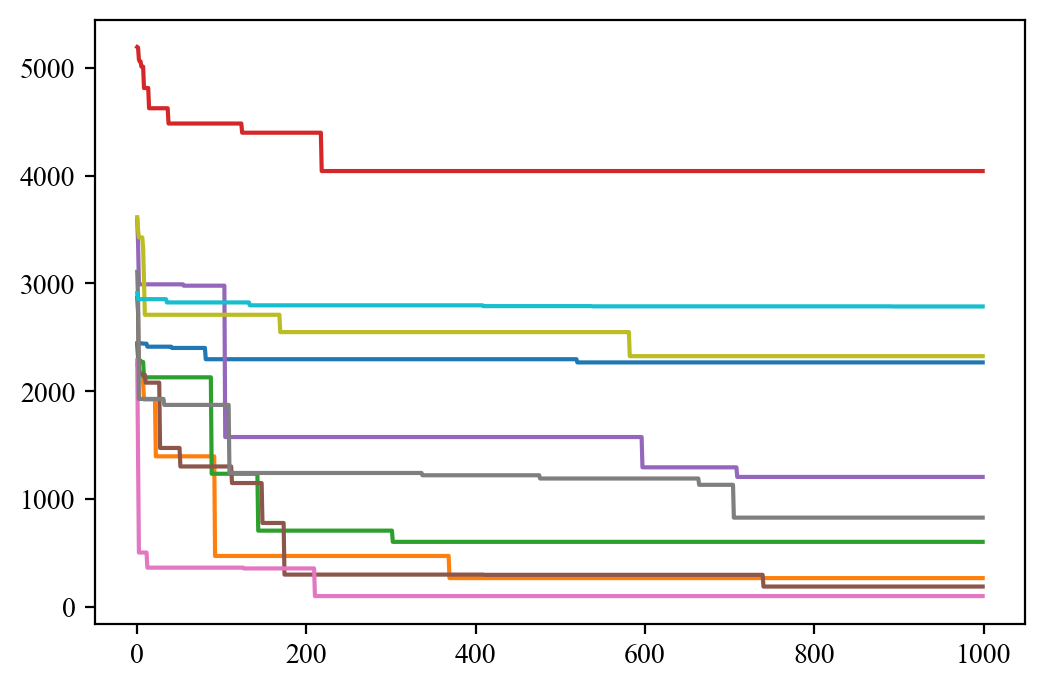

In [119]:
fig, ax = plt.subplots(dpi = 200)
ax.plot(torch.arange(1000),min_reach)

In [118]:
min_reach = reach_est_test.clone()
r0 = reach_est_test[0]
for i in range(999):
    min_reach[i+1][[min_reach[i+1]>min_reach[i]]] = min_reach[i][min_reach[i+1]>min_reach[i]]

In [91]:
reach_est_test[:,1:].shape

torch.Size([1000, 9])

In [109]:
reach_est_test[0]

tensor([2443.7029, 2244.3289, 2418.7498, 5194.2065, 3593.8586, 2866.3311,
        2287.3196, 3107.0820, 3614.0762, 2908.8306])